README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Epoch 1/15:   0%|          | 0/8973 [00:00<?, ?it/s]

/venv/main/lib/python3.10/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


[Epoch 1] Train Loss: 5.9531, Val Loss: 5.3148


Epoch 2/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 5.2366, Val Loss: 5.0175


Epoch 3/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 4.9446, Val Loss: 4.8593


Epoch 4/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 4.7756, Val Loss: 4.7887


Epoch 5/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 4.6658, Val Loss: 4.7532


Epoch 6/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 4.5681, Val Loss: 4.7270


Epoch 7/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 4.5009, Val Loss: 4.7905


Epoch 8/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 8] Train Loss: 4.4200, Val Loss: 4.9622


Epoch 9/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 9] Train Loss: 4.3720, Val Loss: 4.8971


Epoch 10/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 10] Train Loss: 4.2097, Val Loss: 5.1186


Epoch 11/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 11] Train Loss: 4.1517, Val Loss: 5.2819


Epoch 12/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 12] Train Loss: 4.1298, Val Loss: 5.6795


Epoch 13/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 13] Train Loss: 4.0465, Val Loss: 6.0807


Epoch 14/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 14] Train Loss: 4.0139, Val Loss: 6.1537


Epoch 15/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 15] Train Loss: 3.9918, Val Loss: 6.3733

 Test Loss: 6.3529 | Test Accuracy: 0.1889


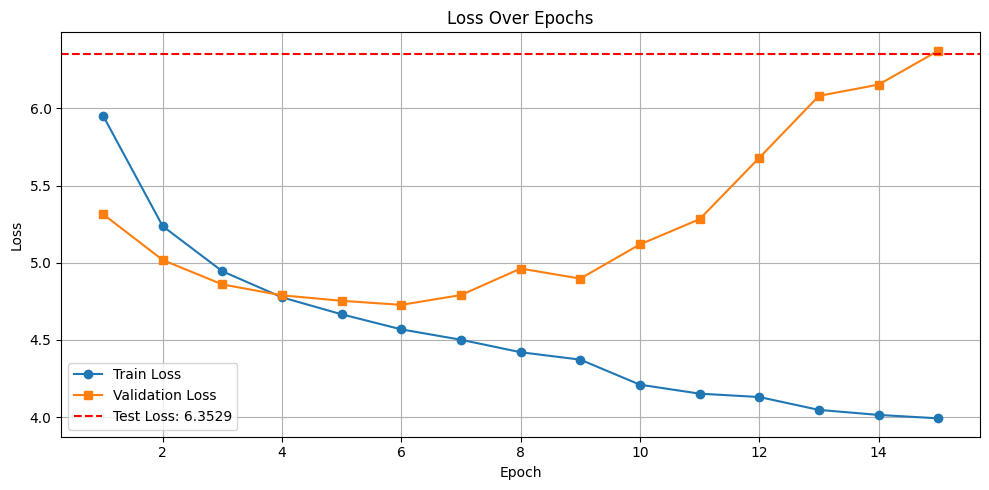

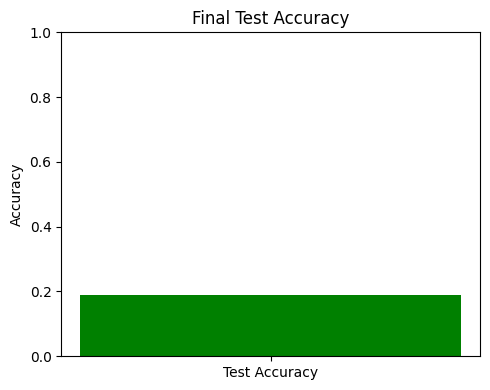

In [3]:
import torch
import torch.nn as nn
from data_utils import get_train_loader, get_val_loader, get_test_loader, set_seed
from baseline_transformer_architecture import create_small_transformer
from modeling_functions import validate_transformer
from optimizer_scheduler import get_optimizer, get_plateau_scheduler, linear_teacher_scheduler
from tokenizers import Tokenizer
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt

class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, ignore_index=1):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(1) - 1))
            mask = target != self.ignore_index
            target = target.masked_fill(~mask, 0)
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
            true_dist.masked_fill_(~mask.unsqueeze(1), 0)
        return torch.mean(torch.sum(-true_dist * pred.log_softmax(dim=1), dim=1))


if __name__ == "__main__":
    torch.cuda.empty_cache()
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #  Lightweight model config
    config = {
        "vocab_size": 20000,
        "dropout": 0.1,
        "d_model": 384,
        "nhead": 6,
        "num_encoder_layers": 4,
        "num_decoder_layers": 4,
        "dim_feedforward": 1536
    }

    tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
    pad_idx = tokenizer.token_to_id("[PAD]")

    model = create_small_transformer(**config).to(device)
    optimizer = get_optimizer(model)
    plateau_scheduler = get_plateau_scheduler(optimizer)
    teacher_scheduler = linear_teacher_scheduler
    criterion = LabelSmoothingLoss(smoothing=0.01, ignore_index=pad_idx)

    #  Reduce batch size for GPU safety
    train_loader = get_train_loader(tokenizer, batch_size=32, num_workers=2)
    val_loader = get_val_loader(tokenizer, batch_size=4, num_workers=0)
    test_loader = get_test_loader(tokenizer, batch_size=4, num_workers=0)

    history = {
        "train_loss": [],
        "val_loss": [],
        "test_loss": None,
        "test_accuracy": None,
        "learning_rate": [],
        "teacher_forcing_ratio": [],
    }

    # === Training Loop ===
    for epoch in range(15):
        model.train()
        total_loss = 0
        tf_ratio = teacher_scheduler.step()

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/15"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attn_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()
            output = model(
                src=input_ids,
                tgt=labels,
                src_key_padding_mask=(attn_mask == 0),
                teacher_forcing_ratio=tf_ratio
            )
            logits = output.view(-1, output.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Clear cache before validation
        torch.cuda.empty_cache()
        val_loss, _ = validate_transformer(model, val_loader, criterion, tokenizer, device, pad_idx, max_length_generate=40)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["learning_rate"].append(optimizer.param_groups[0]['lr'])
        history["teacher_forcing_ratio"].append(tf_ratio)

        plateau_scheduler.step(val_loss)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # === Final Test Evaluation ===
    torch.cuda.empty_cache()
    model.eval()
    correct = total = 0
    total_test_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attn_mask = batch["attention_mask"].to(device)

            output = model(
                src=input_ids,
                tgt=labels,
                src_key_padding_mask=(attn_mask == 0)
            )
            logits = output.view(-1, output.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            total_test_loss += loss.item()

            pred_ids = logits.argmax(dim=-1)
            correct += (pred_ids == targets).sum().item()
            total += targets.numel()

    avg_test_loss = total_test_loss / len(test_loader)
    accuracy = correct / total
    history["test_loss"] = avg_test_loss
    history["test_accuracy"] = accuracy

    print(f"\n Test Loss: {avg_test_loss:.4f} | Test Accuracy: {accuracy:.4f}")

    # === Save history ===
    with open("label_smooth_history.json", "w") as f:
        json.dump(history, f, indent=2)

    # === Plotting ===
    epochs = list(range(1, len(history["train_loss"]) + 1))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="s")
    plt.axhline(y=history["test_loss"], color='r', linestyle='--', label=f"Test Loss: {history['test_loss']:.4f}")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_plot.png")
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.bar(["Test Accuracy"], [history["test_accuracy"]], color='green')
    plt.ylim(0, 1)
    plt.title("Final Test Accuracy")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.savefig("test_accuracy.png")
    plt.show()
